In [2]:
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/dsaproje/cleaned.csv")

df['order_date'] = pd.to_datetime(df['order_date'])


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


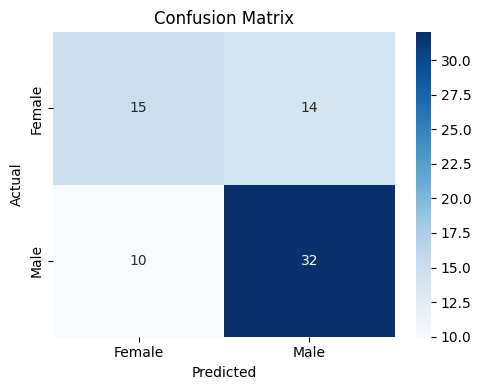

Accuracy: 0.66


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Yalnızca Female ve Male verileri al, eksik olanları çıkar
df_filtered = df[df["guessed_gender"].isin(["Female", "Male"])]
df_filtered = df_filtered.dropna(subset=["category", "city", "day_of_week", "is_weekend", "unit_price", "hour"])

# Özellikler ve hedef
X = df_filtered[["category", "city", "day_of_week", "is_weekend", "unit_price", "hour"]]
y = df_filtered["guessed_gender"]

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kategorik sütunlar
categorical_cols = ["category", "city", "day_of_week", "is_weekend"]

# One-Hot Encoding + Random Forest pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Eğit ve tahmin yap
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["Female", "Male"])

# Görselleştirme
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
